# Convolution NN for first break picking

In [3]:
import numpy as np

from seismicpro.batchflow import Pipeline, Dataset, B, V, F
from seismicpro.batchflow.models.torch import UNet
from seismicpro.src import FieldIndex, TraceIndex, seismic_plot, CustomIndex
from seismicpro.src.picking_batch import PickingBatch

In [4]:
path_raw = 'Pal_Flatiron_1k.sgy'
#path_raw = '../path_to_segy'
index = FieldIndex(name='raw', path=path_raw)

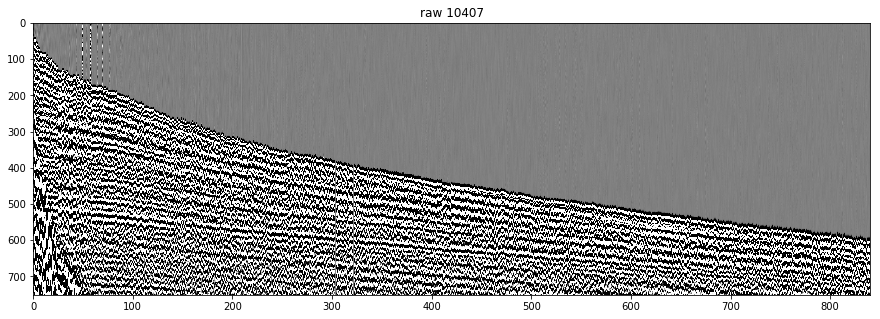

In [5]:
cv = 1000
(Dataset(index, PickingBatch).next_batch(batch_size=1, n_epochs=None)
             .load(components='raw', fmt='segy')
             .seismic_plot('raw', index.indices[0], cmap='gray',
                           figsize=(15,5), vmax=cv, vmin=-cv, s=5, c='r'))

In [6]:
little_index = index.create_subset(index.indices[50:55])
data = Dataset(TraceIndex((little_index)), PickingBatch)

Save the model.

## Inference

Inference pipeline:

In [7]:
model_path = "seismicpro/model/picks_modelUNet_ker5.dill"
config_predict = {
    'build': False,
    'load': {'path': model_path},
    'output/predictions': ['labels'],
    'device': 'cpu'
}


test_pipeline = (Pipeline()
                      .init_model('dynamic', UNet, 'my_model', config=config_predict) 
                      .load(components='raw', fmt='segy')
                      .init_variable('traces', init_on_each_run=list())
                      .update_variable('traces', B('raw'), mode='a')
                      .drop_zero_traces(num_zero=700, src='raw')
                      .normalize(src='raw', dst='raw')
                      .add_components(components='unet_pred')
                      .predict_model('my_model', B('raw'), fetches=['predictions_labels'],
                                     save_to=[B('unet_pred')], mode='a')
                      .mask_to_pick(src='unet_pred', dst='unet_pred')
                      .init_variable('predictions', init_on_each_run=list())
                      .update_variable('predictions', B('unet_pred'), mode='a')
                      .dump(src='unet_pred', fmt='picks',path='WZ_unetpick.csv', traces='raw', to_samples=True))

In [9]:
test = (test_pipeline << data).run(1000, n_epochs=1, drop_last=False, shuffle=False)

In [10]:
raw = np.vstack(np.concatenate(test_pipeline.get_variable('traces')))
pred = np.concatenate(test_pipeline.get_variable('predictions'))

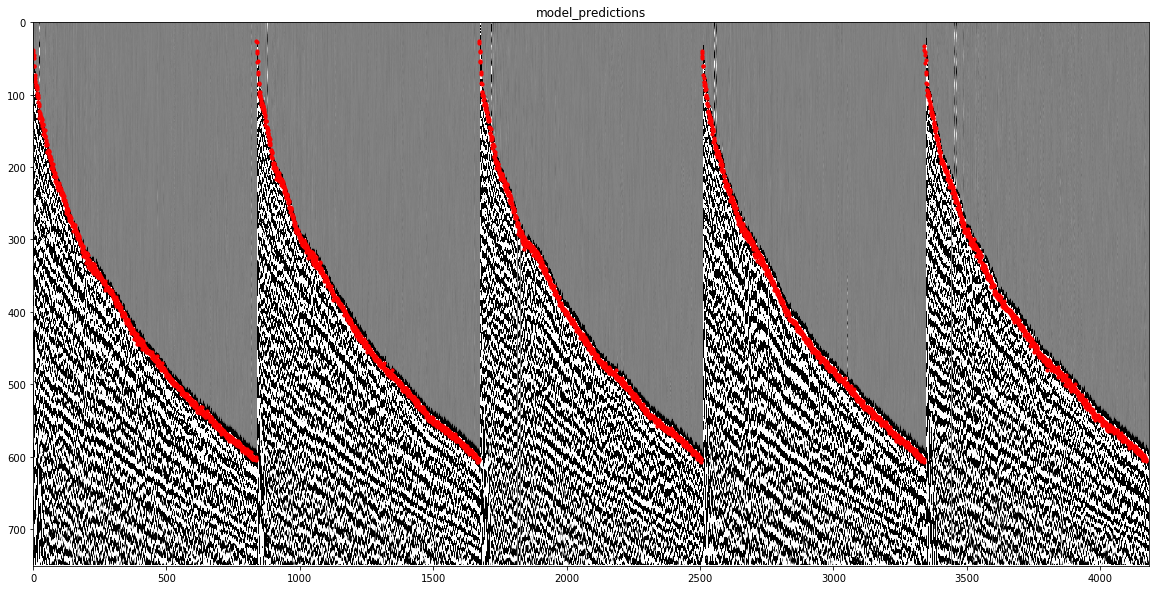

In [11]:
cv = 1000
pts = (range(len(pred)), pred)
seismic_plot(raw, cmap='gray', vmin=-cv, vmax=cv, figsize=(20,10), pts=pts, c='r', s=10, names=['model_predictions'])